In [1]:
import os
import logging
from pathlib import Path
import datetime
import xml.etree.ElementTree as ET

from tqdm import tqdm
import numpy as np
import math
import pandas as pd
import random

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
# Not needed
# from torchvision.transforms import ToTensor 
# from torchvision.transforms.v2 import (Compose, ToImage, ToDtype, 
#                                        Normalize, RandomPhotometricDistort)

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

import torch.nn as nn 
from torch.nn.utils import parameters_to_vector
import torch.optim as optim

import torchmetrics

import cv2

In [2]:
#torch.cuda.empty_cache()

# Logger

In [3]:
log_path = 'results_v0/'

logger = logging.getLogger("GonLogger")
logger.propagate = False
logger.setLevel(logging.INFO)
file_handler = logging.FileHandler(log_path + 'logfile.log')
formatter = logging.Formatter('%(message)s')
file_handler.setFormatter(formatter)

# add file handler to logger
logger.addHandler(file_handler)

logger.info('BED Classifier XS Tiny. Trying to reduce it: v0. 255 Normalization. Weighted for Precision.')

# Config

In [4]:
CLASSES = ["smoke", "fire"]
N_CLASSES = len(CLASSES)

IMG_DIM = {'W':224, 'H':224} # (W, H)
IMG_H = IMG_DIM['H']
IMG_W = IMG_DIM['W']

# Dataset

# DFire

In [5]:
class DFireDataset(Dataset):
    '''
    Creates a Pytorch Dataset to train the Yolov1 Network.
    Encodes labels to match the format [xcell, ycell, w, h, confidence, class_0 (smoke), class_1 (fire)]
        - Final encoding format is: [xcell, ycell, w, h, conf=1, smoke?, fire?]

    Discard images when there are more than 1 object in the same cell
    
    Arguments:
        - img_h:            image height
        - img_w:            image width
        - img_dir:          path to images folder
        - label_dir:        path to labels folder
        - num_classes:      number of classes
        - transform:        transformation applied to input images -> Albumentations
        - target_transform: transformation applied to labels -> nothing by default

    Return:
        - img:              1 image of the dataset
        - target:           corresponding label encoded: [smoke, fire]
    '''

    def __init__(self, img_h, img_w, img_dir, label_dir, num_classes,
                 ds_len,
                 transform=None, target_transform=None):
        self.img_h = img_h
        self.img_w = img_w
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.num_classes = num_classes
        self.ds_len = ds_len
        self.transform = transform
        self.target_transform = target_transform
        
        self.except_transform = A.Compose([
                                    A.Resize(self.img_h, self.img_w, p=1),
                                    #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1), 
                                    ToTensorV2(p=1),
                                    ]
                                )

        self.labels_list = sorted(
            [
                os.path.join(self.label_dir, file_name)
                for file_name in os.listdir(self.label_dir)
                if file_name.endswith(".txt")
            ]
        )
    
        if ds_len is not None:
            random.seed(123)
            random.shuffle(self.labels_list)
            self.images_path, self.labels = self.__build_ds__(self.labels_list[:self.ds_len])
            self.num_samples = len(self.labels_list[:self.ds_len])
        else:
            self.images_path, self.labels = self.__build_ds__(self.labels_list)
            self.num_samples = len(self.labels_list)

    def __len__(self):
        return self.num_samples   

    def __build_ds__(self, labels_list):
        labels = []
        images = []
        wrong_imgs = 0
        empty = 0
        only_smoke = 0
        only_fire = 0
        smoke_fire = 0
                
        for label in labels_list:
            fname = Path(label).stem
            image_path = self.img_dir + fname + '.jpg'   
            #print(fname, image_path)
                                   
            if cv2.imread(image_path) is None:
                print(f'{image_path} cannot be read by cv2 -> removed')
                wrong_imgs += 1
            
            else:
                
                label_array = np.zeros((self.num_classes))
            
                with open(label) as f:
                    lines = f.readlines()
                       
                    for line in lines:
                        class_id, _, _, _, _ = line.strip().split()
                        class_id = int(class_id)
                        if np.array_equal(label_array, np.array([1, 1])):
                            break
                        else:
                            label_array[class_id] = 1.

                    if np.array_equal(label_array, np.array([1, 1])):
                        smoke_fire += 1
                    elif np.array_equal(label_array, np.array([0, 1])):
                        only_fire += 1
                    elif np.array_equal(label_array, np.array([1, 0])):
                        only_smoke += 1
                    elif np.array_equal(label_array, np.array([0, 0])):
                        empty += 1
                    else:
                        print("Wrong label in DFire dataset")
                        logger.info("Wrong label in DFire dataset")
                        
                    labels.append(label_array)
                    images.append(image_path)
        
        print(f'DFire Removed wrong images: {wrong_imgs}')
        logger.info(f'DFire Removed wrong images: {wrong_imgs}')
        print(f'DFire empty images: {empty}')
        logger.info(f'DFire empty images: {empty}')
        print(f'DFire only smoke images: {only_smoke}')
        logger.info(f'DFire only smoke images: {only_smoke}')
        print(f'DFire only fire images: {only_fire}')
        logger.info(f'DFire only fire images: {only_fire}')
        print(f'DFire smoke and fire images: {smoke_fire}')
        logger.info(f'DFire smoke and fire images: {smoke_fire}')

        labels_np = np.array(labels)
        labels_tensor = torch.tensor(labels_np, dtype=torch.float32)
        images_array = np.array(images)
        
        return images_array, labels_tensor

    def __getitem__(self, index):

        # Image processing
        img_file = self.images_path[index]
        img = cv2.imread(img_file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   

        # Labels processing
        label = self.labels[index]
        
        # Data Augmentation
        if self.transform is not None:
            try:
                aug = self.transform(image=img)
                img = aug['image'] / 255.0
            except:
                #print(f'Error trying to augment image {img_file}')
                aug = self.except_transform(image=img)
                img = aug['image'] / 255.0
        
        return img, label

### View Dataset

In [6]:
ds_dir = '../../../datasets/ds2fire/dfire_yolo/'

train_dir = ds_dir + 'train/'
train_imgs = train_dir + 'images/'
train_labels = train_dir + 'labels/'

#val_dir = ds_dir + 'test/'

val_dir = ds_dir + 'test/'
val_imgs = val_dir + 'images/'
val_labels = val_dir + 'labels/'

print(f'Train dir: {os.listdir(train_dir)}')
print(f'val dir: {os.listdir(val_dir)}')

Train dir: ['labels', '.ipynb_checkpoints', 'images']
val dir: ['labels', '.ipynb_checkpoints', 'images']


### Transform

In [7]:
view_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(IMG_H, IMG_W, p=1),
        ToTensorV2(p=1),
    ]
)

In [8]:
VIEW_BATCH_SIZE = 32

view_dfire_ds = DFireDataset(img_h=IMG_H, 
                             img_w=IMG_W, 
                             img_dir=val_imgs, 
                             label_dir=val_labels, 
                             num_classes=N_CLASSES,
                             ds_len=2*VIEW_BATCH_SIZE,
                             transform=view_transform)

view_loader = DataLoader(dataset=view_dfire_ds,
                         batch_size=VIEW_BATCH_SIZE,
                         num_workers=1,
                         pin_memory=True,
                         shuffle=True,
                         drop_last=False)
print(f'Val dataset length: {len(view_dfire_ds)}')

DFire Removed wrong images: 0
DFire empty images: 31
DFire only smoke images: 17
DFire only fire images: 2
DFire smoke and fire images: 14
Val dataset length: 64


# Plot Dataset Pictures

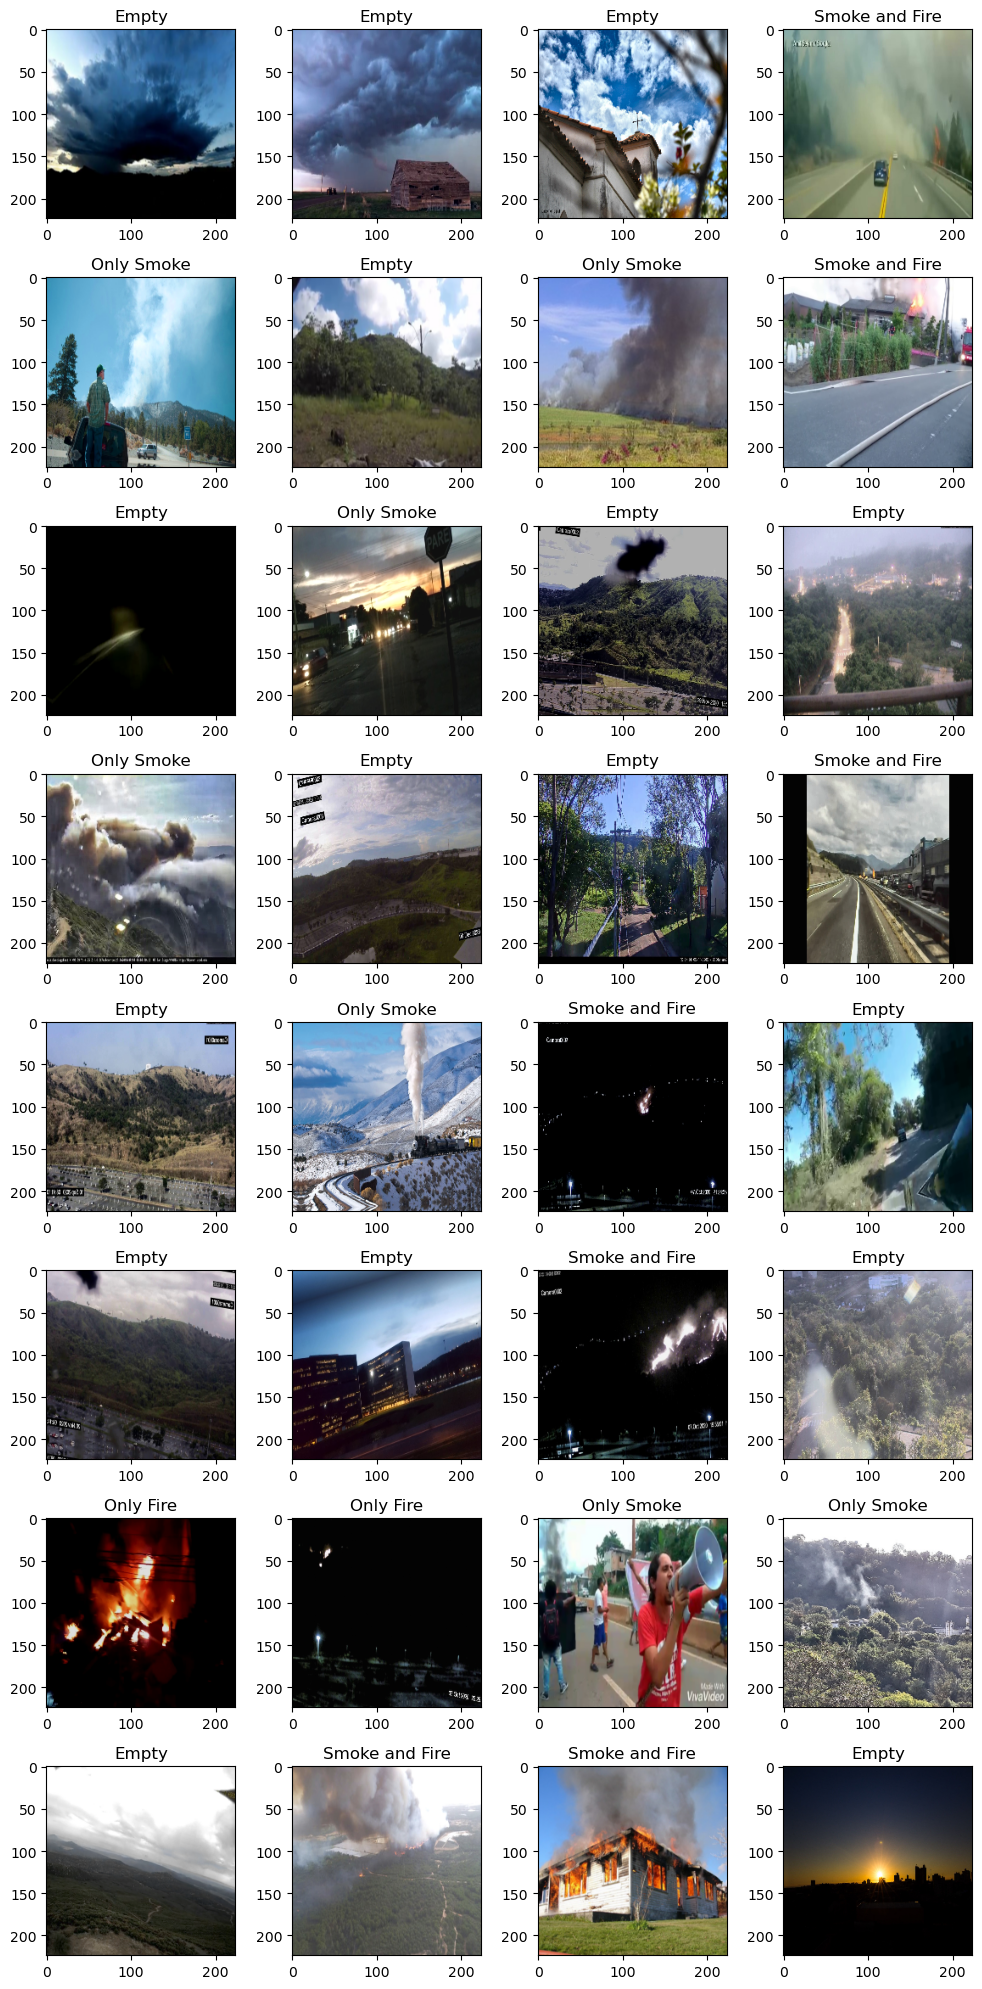

In [9]:
for i, (img, label) in enumerate(view_loader):

    plt.subplots(8,4, figsize=(10, 20))
    
    for idx in range(VIEW_BATCH_SIZE):
        plt.subplot(8, 4, idx+1)
        plt.imshow(img[idx].permute(1, 2, 0))
        title = ""
        if label[idx][0] == 1 and label[idx][1] == 1:
            title += "Smoke and Fire"
        elif label[idx][0] == 1 and label[idx][1] == 0:
            title += "Only Smoke"
        elif label[idx][0] == 0 and label[idx][1] == 1:
            title += "Only Fire"
        else:
            title += "Empty"
        plt.title(title)
        
        if (idx == 31):
            break
    plt.tight_layout()
    plt.show()
    break

# Model: BED Less Layers

In [10]:
class BED_CLASSIFIER(nn.Module):
    def __init__(self, num_classes, in_channels=3):
        super(BED_CLASSIFIER, self).__init__()
        self.in_channels = in_channels
        self.last_channels = 32
        self.num_classes = num_classes
        
        self.model = self.__create_BED__()
        
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.smoke = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=self.last_channels, out_features=8),
            nn.ReLU(),
            nn.Linear(in_features=8, out_features=1)
        )
        self.fire = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=self.last_channels, out_features=8),
            nn.ReLU(),
            nn.Linear(in_features=8, out_features=1)
        )

        
    def __create_BED__(self):
        BED_model = nn.Sequential(
            # Conv2d [in_channels, out_channels, kernel_size, stride, padding, bias]

            # CNNBlock 224x224
            nn.Conv2d(self.in_channels, 32, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            nn.Dropout2d(p=0.3),

            # CNNBlock 112x112
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(16, affine=False),
            nn.ReLU(),
            nn.Dropout2d(p=0.3),

            # CNNBlock 56x56
            nn.MaxPool2d(kernel_size=2, stride=2),
            # kernel = 1 in github
            nn.Conv2d(16, 8, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(8, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(16, affine=False),
            nn.ReLU(),
            
            # kernel = 1 in github
            nn.Conv2d(16, 16, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(16, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),

            # CNNBlock 28x28
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 16, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(16, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 16, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(16, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 16, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(16, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),

            # CNNBlock 14x14
#             nn.MaxPool2d(kernel_size=2, stride=2), 
#             nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
#             nn.BatchNorm2d(32, affine=False),
#             nn.ReLU(),
            
#             nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
#             nn.BatchNorm2d(64, affine=False),
#             nn.ReLU(),
            
#             nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
#             nn.BatchNorm2d(32, affine=False),
#             nn.ReLU(),
            
#             nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
#             nn.BatchNorm2d(64, affine=False),
#             nn.ReLU(),
            
#             nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1,  bias=False),
#             nn.BatchNorm2d(64, affine=False),
#             nn.ReLU(),
            
#             nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1,  bias=False),
#             nn.BatchNorm2d(64, affine=False),
#             nn.ReLU(),
            
#             # CNNBlock 7x7
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1,  bias=False),
#             nn.BatchNorm2d(128, affine=False),
#             nn.ReLU(),
#             nn.Conv2d(128, self.last_channels, kernel_size=3, stride=1, padding=1,  bias=False),
#             nn.BatchNorm2d(self.last_channels, affine=False),
#             nn.ReLU(),
            
        )
        return BED_model
        
          

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in',
                    nonlinearity='relu'
                )
                if m.bias is not None:
                        nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


    def forward(self, x):
        x = self.model(x)
        x = self.pool(x)
        x = torch.flatten(x, start_dim=1)
        x = torch.cat((self.smoke(x), self.fire(x)), dim=-1)
        #x = torch.sigmoid(x) # BCE Logits
        return x

# Loss

In [11]:
class BCE_LOSS(nn.Module):
    '''
    dataset output: (image, {smoke: x, fire: x})
    model output: {smoke: x, fire: x}
    '''

    def __init__(self, device, smoke_precision_weight):
        super(BCE_LOSS, self).__init__()
        self.smoke_precision_weight = smoke_precision_weight
        self.device = device
        #self.bce = nn.BCELoss(reduction='mean')
        self.pos_weight = torch.tensor([self.smoke_precision_weight]).to(self.device)
        self.bce_smoke = nn.BCEWithLogitsLoss(reduction='sum', pos_weight=self.pos_weight)
        self.bce_fire = nn.BCEWithLogitsLoss(reduction='sum')
        
        self.eps = 1e-10
        
        self.smoke_loss = 0
        self.fire_loss = 0

    def forward(self, ground_truth, predictions):
        
        # print(f'Ground trunth: {ground_truth}')
        # print(f'Predictions: {predictions}')
        
        # BCELoss: ALWAYS (prediction, target) -> it crashes with NaN if order is wrong
        smoke_loss = self.bce_smoke(predictions[..., 0],
                                    ground_truth[..., 0])
        self.smoke_loss = smoke_loss.item()
        fire_loss = self.bce_fire(predictions[..., 1],
                                  ground_truth[..., 1])
        self.fire_loss = fire_loss.item()
        
        total_loss = smoke_loss + fire_loss
        
        return total_loss

    def get_last_losses(self):     
        return {
            'smoke_loss': self.smoke_loss,
            'fire_loss': self.fire_loss,
        }

# Hyperparameters

In [12]:
''' ============================
    Hyperparameters and More
============================ '''

MODEL = "BED"
#MODEL = "SQUEEZE"

#LEARNING_RATE = 5e-4
LEARNING_RATE = 0.001
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
#DEVICE = "cpu"
BATCH_SIZE = 64 
WEIGHT_DECAY = 1e-4
#WEIGHT_DECAY = 0
EPOCHS = 150 #100
NUM_WORKERS = 4
PIN_MEMORY = True
LOAD_MODEL = False
if MODEL == "BED":
    LOAD_MODEL_FILE = log_path + MODEL + "_classifier_best.pt"
elif MODEL == "SQUEEZE":
    LOAD_MODEL_FILE = log_path + MODEL + "_classifier_best.pt"

LOSS_FN = "BCE"
SMOKE_PRECISION_WEIGHT = 0.7

TRAIN_IMG_DIR = train_imgs
TRAIN_LABEL_DIR = train_labels
VAL_IMG_DIR = val_imgs
VAL_LABEL_DIR = val_labels

LOG_FILE = "log_file.xlsx"

DS_LEN = None


''' ============================
    Metrics
============================ '''
# Loss output
## Train
train_total_loss = []
train_smoke_loss = []
train_fire_loss = []
## Val
val_total_loss = []
val_smoke_loss = []
val_fire_loss = []

# Accuracy, Precision, Recall, F1
## Train
train_smoke_total_accuracy = []
train_smoke_total_precision = []
train_smoke_total_recall = []
train_smoke_total_f1 = []
train_fire_total_accuracy = []
train_fire_total_precision = []
train_fire_total_recall = []
train_fire_total_f1 = []
## Val
val_smoke_total_accuracy = []
val_smoke_total_precision = []
val_smoke_total_recall = []
val_smoke_total_f1 = []
val_fire_total_accuracy = []
val_fire_total_precision = []
val_fire_total_recall = []
val_fire_total_f1 = []

epochs_plot = []

# Metrics

In [13]:
precision_metric = torchmetrics.classification.MultilabelPrecision(num_labels = N_CLASSES, 
                                                                   threshold = 0.5, 
                                                                   average = None).to(DEVICE)
recall_metric = torchmetrics.classification.MultilabelRecall(num_labels = N_CLASSES, 
                                                             threshold = 0.5, 
                                                             average = None).to(DEVICE)
accuracy_metric = torchmetrics.classification.MultilabelAccuracy(num_labels = N_CLASSES, 
                                                                 threshold = 0.5, 
                                                                 average = None).to(DEVICE)
f1_metric = torchmetrics.classification.MultilabelF1Score(num_labels = N_CLASSES, 
                                                          threshold = 0.5, 
                                                          average = None).to(DEVICE)

# Train Loop

In [14]:
'''
Train function
'''
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def train_fn(loader, model, optimizer, loss_fn, device):
    
    print(f'Learning Rate = {get_lr(optimizer=optimizer)}\n')
    logger.info(f'Learning Rate = {get_lr(optimizer=optimizer)}')

    model.train()
    loop = tqdm(loader, desc='Training', leave=True)
    train_losses = []
    smoke_losses = []
    fire_losses = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(device), y.to(device)
        out = model(x)
        train_loss = loss_fn(ground_truth=y, 
                             predictions=out)
      
        # Gradient Descent
        optimizer.zero_grad()
        train_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
        optimizer.step()

        # BCE Loss
        last_losses = loss_fn.get_last_losses()
        train_losses.append(train_loss.item())
        smoke_losses.append(last_losses['smoke_loss'])
        fire_losses.append(last_losses['fire_loss'])
        
        # print(f'Train loss: {train_loss}')
        # print(f'Train loss: {train_losses}')
        
        model.eval()
        # Metrics -> Maybe change to metric.update(), sin hacer precision = ...
        yhat = torch.sigmoid(out.detach())
        precision_metric.update(yhat, y)
        recall = recall_metric.update(yhat, y)
        accuracy = accuracy_metric.update(yhat, y)
        f1 = f1_metric.update(yhat, y)
        model.train()
    
    model.eval()
    precision = precision_metric.compute()
    recall = recall_metric.compute()
    accuracy = accuracy_metric.compute()
    f1 = f1_metric.compute()
    model.train()
        
    logger.info("\nTRAIN losses")
    train_mean_loss = sum(train_losses)/len(train_losses)
    smoke_mean_loss = sum(smoke_losses)/len(smoke_losses)
    fire_mean_loss = sum(fire_losses)/len(fire_losses)


    print("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    print("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    print(f'{train_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")
    
    logger.info("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    logger.info("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    logger.info(f'{train_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")   
    
    precision_metric.reset()
    recall_metric.reset()
    accuracy_metric.reset()
    f1_metric.reset()
    
    return (train_mean_loss, 
            smoke_mean_loss, 
            fire_mean_loss,
            accuracy,
            precision,
            recall,
            f1)

# Validation Loop

In [15]:
'''
Evaluation Function
'''
def eval_fn(loader, model, loss_fn, device):
    
    model.eval()
    loop = tqdm(loader, desc='Validating', leave=True)
    val_losses = []
    smoke_losses = []
    fire_losses = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(device), y.to(device)
        out = model(x)
        val_loss = loss_fn(ground_truth=y, 
                           predictions=out)      
        
        # BCE Loss
        last_losses = loss_fn.get_last_losses()
        val_losses.append(val_loss.item())
        smoke_losses.append(last_losses['smoke_loss'])
        fire_losses.append(last_losses['fire_loss'])
    
        # Metrics -> Maybe change to metric.update(), sin hacer precision = ...
        yhat = torch.sigmoid(out.detach())
        precision_metric.update(yhat, y)
        recall = recall_metric.update(yhat, y)
        accuracy = accuracy_metric.update(yhat, y)
        f1 = f1_metric.update(yhat, y)
    
    precision = precision_metric.compute()
    recall = recall_metric.compute()
    accuracy = accuracy_metric.compute()
    f1 = f1_metric.compute()

    logger.info("\nVAL losses")
    val_mean_loss = sum(val_losses)/len(val_losses)
    smoke_mean_loss = sum(smoke_losses)/len(smoke_losses)
    fire_mean_loss = sum(fire_losses)/len(fire_losses)

    print("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    print("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    print(f'{val_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")
    
    logger.info("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    logger.info("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    logger.info(f'{val_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")   

    logger.info("VAL Metrics")
    print(f'SMOKE -> Precision: {precision[0]:.3f} - Recall: {recall[0]:.3f} - Accuracy: {accuracy[0]:.3f} - F1: {f1[0]:.3f}')
    logger.info(f'SMOKE -> Precision: {precision[0]:.3f} - Recall: {recall[0]:.3f} - Accuracy: {accuracy[0]:.3f} - F1: {f1[0]:.3f}')
    print(f'FIRE -> Precision: {precision[1]:.3f} - Recall: {recall[1]:.3f} - Accuracy: {accuracy[1]:.3f} - F1: {f1[1]:.3f}')
    logger.info(f'FIRE -> Precision: {precision[1]:.3f} - Recall: {recall[1]:.3f} - Accuracy: {accuracy[1]:.3f} - F1: {f1[1]:.3f}')
    
    precision_metric.reset()
    recall_metric.reset()
    accuracy_metric.reset()
    f1_metric.reset()
    
    return (val_mean_loss, 
            smoke_mean_loss, 
            fire_mean_loss,
            accuracy,
            precision,
            recall,
            f1)

# Dataset Setup

In [16]:
train_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(IMG_H, IMG_W, p=1),
        #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1),
        ToTensorV2(p=1),
    ]
)

# TRAIN DATASET
print("\nTRAIN DFIRE dataset")
logger.info("\nTRAIN DFIRE dataset")
train_dataset = DFireDataset(img_h = IMG_H,
                             img_w = IMG_W,
                             img_dir = TRAIN_IMG_DIR,
                             label_dir = TRAIN_LABEL_DIR,
                             num_classes=N_CLASSES,
                             ds_len = DS_LEN,
                             transform=train_transform)

print(f'Train dataset len: {len(train_dataset)}')
logger.info(f'Train dataset len: {len(train_dataset)}')


# VALIDATION DATASET
val_transform = A.Compose([
    A.Resize(IMG_H, IMG_W, p=1),
    #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1), # Removed to divide by 255. in dataset
    ToTensorV2(p=1),
    ]
)

print("\nTEST DFire dataset")
logger.info("\nTEST DFire dataset")
val_dataset = DFireDataset(img_h = IMG_H,
                           img_w = IMG_W,
                           img_dir = VAL_IMG_DIR,
                           label_dir = VAL_LABEL_DIR,
                           num_classes = N_CLASSES,
                           ds_len = DS_LEN,
                           transform=val_transform)

print(f'Test dataset len: {len(val_dataset)}')
logger.info(f'Test dataset len: {len(val_dataset)}')


# LOADERS
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS,
                          pin_memory=PIN_MEMORY,
                          shuffle=True,
                          drop_last=True)

val_loader = DataLoader(dataset=val_dataset,
                        batch_size=BATCH_SIZE,
                        num_workers=NUM_WORKERS,
                        pin_memory=PIN_MEMORY,
                        shuffle=False,
                        drop_last=True)


TRAIN DFIRE dataset
DFire Removed wrong images: 0
DFire empty images: 7833
DFire only smoke images: 4681
DFire only fire images: 944
DFire smoke and fire images: 3763
Train dataset len: 17221

TEST DFire dataset
DFire Removed wrong images: 0
DFire empty images: 2005
DFire only smoke images: 1186
DFire only fire images: 220
DFire smoke and fire images: 895
Test dataset len: 4306


# Model Setup

In [17]:
''' ======================================
    SETUP: Model, Loss, Dataset, Loader
====================================== '''
if MODEL == "BED":
    print("Using BED Classifier")
    logger.info("Using BED Classifier")
    model = BED_CLASSIFIER(num_classes=N_CLASSES).to(DEVICE)
elif MODEL == "SQUEEZE":
    print("Using Squeeze Classifier")
    logger.info("Using Squeeze Classifier")
    model = SqueezeNet(num_classes=N_CLASSES).to(DEVICE)    
else:
    print("Wrong Model")
    logger.info("Wrong Model")
    raise SystemExit("Wrong Model")

# Check model shape
in_rand_np = np.random.rand(4, 3, IMG_H, IMG_W)
in_rand = torch.tensor(in_rand_np, dtype=torch.float32, device=DEVICE)
out_test = model(in_rand)
print(f'Model shape is {out_test}')
print(f'BED Model Arquitecture\n{model}')
logger.info(f'Model shape is {out_test}')
logger.info(f'BED Model Arquitecture\n{model}')


optimizer = optim.Adam(model.parameters(), 
                       lr=LEARNING_RATE, 
                       weight_decay=WEIGHT_DECAY)
# optimizer = torch.optim.SGD(model.parameters(), 
#                             lr=LEARNING_RATE,
#                             momentum=0.9, 
#                             weight_decay=WEIGHT_DECAY, 
#                             nesterov=True)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min',
                                                 factor=0.8, 
                                                 patience=2, 
                                                 threshold=0.001, 
                                                 threshold_mode='abs',
                                                 min_lr=1e-6)

# MODEL PARAMETERS
n_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'\nTrainable parameters = {n_trainable}')
logger.info(f'\nTrainable parameters = {n_trainable}')

n_params = parameters_to_vector(model.parameters()).numel()
print(f'Total parameters = {n_params}\n')
logger.info(f'Total parameters = {n_params}\n')

Using BED Classifier
Model shape is tensor([[0.1316, 0.3222],
        [0.1125, 0.3415],
        [0.0906, 0.3886],
        [0.0607, 0.3386]], device='cuda:0', grad_fn=<CatBackward0>)
BED Model Arquitecture
BED_CLASSIFIER(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.3, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (7): ReLU()
    (8): Dropout2d(p=0.3, inplace=False)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (11): BatchNorm2d(8, eps=1e-05, momentum=0.1, 

# Main Function

In [18]:
def main(model):

    ''' ============================
        Print Config Values
    ============================ '''
    print(f'Device: {DEVICE}')
    print(f'Learning Rate: {LEARNING_RATE}')
    print(f'Weight Decay: {WEIGHT_DECAY}')
    print(f'Batch Size: {BATCH_SIZE}')
    print(f'IMG DIMS: ({IMG_H}, {IMG_W})')
    print(f'W: {IMG_W}\nH: {IMG_H}')
    
    logger.info(f'Device: {DEVICE}')
    logger.info(f'Learning Rate: {LEARNING_RATE}')
    logger.info(f'Weight Decay: {WEIGHT_DECAY}')
    logger.info(f'Batch Size: {BATCH_SIZE}')
    logger.info(f'IMG DIMS: ({IMG_H}, {IMG_W})')
    logger.info(f'W: {IMG_W}\nH: {IMG_H}')

    
    # LOSS FUNCTION
    if LOSS_FN == "BCE":
        print(f'Loss Function: BCE')
        logger.info(f'Loss Function: BCE')
        print(f'Smoke Precision Weight: {SMOKE_PRECISION_WEIGHT}')
        logger.info(f'Smoke Precision Weight: {SMOKE_PRECISION_WEIGHT}')
        loss_fn = BCE_LOSS(device=DEVICE, smoke_precision_weight=SMOKE_PRECISION_WEIGHT)
    else:
        print("Wrong loss function")
        logger.info("Wrong loss function")
        raise SystemExit("Wrong loss function")

    ''' ==============================================================
                                TRAINING LOOP
    ============================================================== '''
    # Start with infinite validation loss
    best_valid_loss = np.inf
    best_smoke_precision = torch.tensor([0.])
    smoke_f1_min_save = torch.tensor([0.9])

    start = datetime.datetime.now()
    start_time = start.strftime("%H:%M:%S")
    print(f'\n***Start Training: {start_time}\n')
    logger.info(f'\n***Start Training: {start_time}\n')

    start_epoch = 0

    if LOAD_MODEL == False:
        if MODEL == "BED":
            model._initialize_weights()
            print("Initializing Weights")
            logger.info("Initializing Weights")
        elif MODEL == "SQUEEZE":
            print("Weights already initialize in model call")
            logger.info("Weights already initialize in model call")
    else:
        checkpoint = torch.load(LOAD_MODEL_FILE)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch']
        print(f"Loading Model. Train from epoch: {start_epoch}")
        logger.info(f"Loading Model. Train from epoch: {start_epoch}")
        
    for epoch in range(start_epoch, EPOCHS):

        print(f'\n=== EPOCH {epoch}/{EPOCHS-1} ===')
        logger.info(f'\n=== EPOCH {epoch}/{EPOCHS-1} ===')
        
        # TRAINING
        train_loss, smoke_loss, fire_loss, tr_acc, tr_pre, tr_rec, tr_f1 = train_fn(loader=train_loader, 
                                                                                    model=model, 
                                                                                    optimizer=optimizer, 
                                                                                    loss_fn=loss_fn,
                                                                                    device=DEVICE)
        # Appending Train Losses
        train_total_loss.append(train_loss)
        train_smoke_loss.append(smoke_loss)
        train_fire_loss.append(fire_loss)
        # Appending Train Metrics
        train_smoke_total_accuracy.append(tr_acc[0].detach().to('cpu'))
        train_smoke_total_precision.append(tr_pre[0].detach().to('cpu'))
        train_smoke_total_recall.append(tr_rec[0].detach().to('cpu'))
        train_smoke_total_f1.append(tr_f1[0].detach().to('cpu'))
        train_fire_total_accuracy.append(tr_acc[1].detach().to('cpu'))
        train_fire_total_precision.append(tr_pre[1].detach().to('cpu'))
        train_fire_total_recall.append(tr_rec[1].detach().to('cpu'))
        train_fire_total_f1.append(tr_f1[1].detach().to('cpu'))
        
        # VALIDATING
        with torch.no_grad():
            val_loss, smoke_loss, fire_loss, v_acc, v_pre, v_rec, v_f1 = eval_fn(loader=val_loader, 
                                                                                 model=model,                         
                                                                                 loss_fn=loss_fn,
                                                                                 device=DEVICE)
            # Appending Validation Losses
            val_total_loss.append(val_loss)
            val_smoke_loss.append(smoke_loss)
            val_fire_loss.append(fire_loss)
            # Appending Validation Metrics
            val_smoke_total_accuracy.append(v_acc[0].detach().to('cpu'))
            val_smoke_total_precision.append(v_pre[0].detach().to('cpu'))
            val_smoke_total_recall.append(v_rec[0].detach().to('cpu'))
            val_smoke_total_f1.append(v_f1[0].detach().to('cpu'))
            val_fire_total_accuracy.append(v_acc[1].detach().to('cpu'))
            val_fire_total_precision.append(v_pre[1].detach().to('cpu'))
            val_fire_total_recall.append(v_rec[1].detach().to('cpu'))
            val_fire_total_f1.append(v_f1[1].detach().to('cpu'))
            
            scheduler.step(val_loss)
            

            epochs_plot.append(epoch)
            plt.plot(epochs_plot, train_total_loss, label="Train Loss")
            plt.plot(epochs_plot, val_total_loss, label="Val Loss")
            plt.title("Train vs Val Loss")
            plt.xlabel("Epochs")
            plt.ylabel("Loss")
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_loss.png")
            plt.close()
            
            # Accuracy
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_accuracy, label="Smoke Train Acc")
            plt.plot(epochs_plot, val_smoke_total_accuracy, label="Smoke Val Acc")
            plt.title("Smoke Train vs Val Acc")
            plt.xlabel("Epochs")
            plt.ylabel("Accuracy")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_smoke_acc.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_accuracy, label="Fire Train Acc")
            plt.plot(epochs_plot, val_fire_total_accuracy, label="Fire Val Acc")
            plt.title("Fire Train vs Val Acc")
            plt.xlabel("Epochs")
            plt.ylabel("Accuracy")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_fire_acc.png")
            plt.close()
            # Precision
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_precision, label="Smoke Train Prec")
            plt.plot(epochs_plot, val_smoke_total_precision, label="Smoke Val Prec")
            plt.title("Smoke Train vs Val Precision")
            plt.xlabel("Epochs")
            plt.ylabel("Precision")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_smoke_prec.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_precision, label="Fire Train Prec")
            plt.plot(epochs_plot, val_fire_total_precision, label="Fire Val Prec")
            plt.title("Fire Train vs Val Prec")
            plt.xlabel("Epochs")
            plt.ylabel("Precision")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_fire_prec.png")
            plt.close()
            # Recall
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_recall, label="Smoke Train Rec")
            plt.plot(epochs_plot, val_smoke_total_recall, label="Smoke Val Rec")
            plt.title("Smoke Train vs Val Rec")
            plt.xlabel("Epochs")
            plt.ylabel("Recall")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_smoke_rec.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_recall, label="Fire Train Rec")
            plt.plot(epochs_plot, val_fire_total_recall, label="Fire Val Rec")
            plt.title("Fire Train vs Val Rec")
            plt.xlabel("Epochs")
            plt.ylabel("Recall")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_fire_rec.png")
            plt.close()
            # F1
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_f1, label="Smoke Train F1")
            plt.plot(epochs_plot, val_smoke_total_f1, label="Smoke Val F1")
            plt.title("Smoke Train vs Val F1")
            plt.xlabel("Epochs")
            plt.ylabel("F1")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_smoke_f1.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_f1, label="Fire Train F1")
            plt.plot(epochs_plot, val_fire_total_f1, label="Fire Val F1")
            plt.title("Fire Train vs Val F1")
            plt.xlabel("Epochs")
            plt.ylabel("F1")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_fire_f1.png")
            plt.close()

        if ( (epoch+1) % 5 ) == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict()}, log_path + MODEL + '_classifier_5epoch.pt') 
            
        if best_valid_loss > val_loss:
            best_valid_loss = val_loss
            print(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            logger.info(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict()}, log_path + 'best_' + MODEL + '_classifier.pt') 

        # Save model if precision increases and F1 > 0.9
        if ( best_smoke_precision < v_pre[0].detach().to('cpu') ) and ( v_f1[0].detach().to('cpu') > smoke_f1_min_save ) :
            best_smoke_precision = v_pre[0].detach().to('cpu')
            print(f"\nSaving model with new best smoke precision: {best_smoke_precision:.3f}")
            logger.info(f"\nSaving model with new best smoke precision: {best_smoke_precision:.3f}")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict()}, log_path + 'best_smoke_' + MODEL + '_classifier.pt') 
        
    logger.info('Saving last model')   
    torch.save(model.state_dict(), log_path + 'last_bed_classifier.pt') 
    
#     save_log(epochs=EPOCHS, 
#              train_total_loss=train_total_loss,
#              train_box_loss=train_box_loss,
#              train_class_loss=train_class_loss,
#              train_confidence_loss=train_confidence_loss,
#              train_noobj_loss=train_noobj_loss,
#              train_mAP=train_mAP,
#              train_class_AP=train_class_AP,
#              train_class_precision=train_class_precision,
#              train_class_recall=train_class_recall,
#              val_total_loss=val_total_loss,
#              val_box_loss=val_box_loss,
#              val_class_loss=val_class_loss,
#              val_confidence_loss=val_confidence_loss,
#              val_noobj_loss=val_noobj_loss,
#              val_mAP=val_mAP,
#              val_class_AP=val_class_AP,
#              val_class_precision=val_class_precision,
#              val_class_recall=val_class_recall,
#              log_file_dst=LOG_FILE)

    end = datetime.datetime.now()
    end_time = end.strftime("%H:%M:%S")
    print(f'\n***Script finished: {end_time}\n')  
    print(f'Time elapsed: {end-start}')
    logger.info(f'\n***Script finished: {end_time}\n')  
    logger.info(f'Time elapsed: {end-start}')
    
    return model

# Main execute

In [19]:
if __name__ == "__main__":
    print("Starting script\n")
    logger.info("Starting script\n")
    model_trained = main(model=model)

Starting script

Device: cuda
Learning Rate: 0.001
Weight Decay: 0.0001
Batch Size: 64
IMG DIMS: (224, 224)
W: 224
H: 224
Loss Function: BCE
Smoke Precision Weight: 0.7

***Start Training: 16:44:26

Initializing Weights

=== EPOCH 0/149 ===
Learning Rate = 0.001



Training:   0%|                                         | 0/269 [00:00<?, ?it/s]/opt/conda/envs/pytorch_env/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608935911/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.19it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
69.767      |36.729      |33.038      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
61.977      |36.244      |25.733      

SMOKE -> Precision: 0.000 - Recall: 0.000 - Accuracy: 0.519 - F1: 0.000
FIRE -> Precision: 0.000 - Recall: 0.000 - Accuracy: 0.741 - F1: 0.000

Saving model with new best validation loss: 61.977

=== EPOCH 1/149 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.20it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
63.696      |36.174      |27.522      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
59.830      |35.721      |24.109      

SMOKE -> Precision: 0.000 - Recall: 0.000 - Accuracy: 0.519 - F1: 0.000
FIRE -> Precision: 0.756 - Recall: 0.552 - Accuracy: 0.838 - F1: 0.638

Saving model with new best validation loss: 59.830

=== EPOCH 2/149 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
62.062      |35.969      |26.093      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
58.970      |35.468      |23.503      

SMOKE -> Precision: 0.000 - Recall: 0.000 - Accuracy: 0.519 - F1: 0.000
FIRE -> Precision: 0.692 - Recall: 0.675 - Accuracy: 0.838 - F1: 0.683

Saving model with new best validation loss: 58.970

=== EPOCH 3/149 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.11it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
61.294      |35.659      |25.635      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
57.918      |35.217      |22.702      

SMOKE -> Precision: 0.608 - Recall: 0.270 - Accuracy: 0.565 - F1: 0.374
FIRE -> Precision: 0.739 - Recall: 0.650 - Accuracy: 0.850 - F1: 0.692

Saving model with new best validation loss: 57.918

=== EPOCH 4/149 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
60.422      |35.432      |24.990      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
57.004      |35.070      |21.934      

SMOKE -> Precision: 0.636 - Recall: 0.315 - Accuracy: 0.583 - F1: 0.421
FIRE -> Precision: 0.730 - Recall: 0.693 - Accuracy: 0.854 - F1: 0.711

Saving model with new best validation loss: 57.004

=== EPOCH 5/149 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.21it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
59.510      |35.214      |24.296      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
56.357      |34.840      |21.517      

SMOKE -> Precision: 0.632 - Recall: 0.316 - Accuracy: 0.583 - F1: 0.421
FIRE -> Precision: 0.738 - Recall: 0.668 - Accuracy: 0.853 - F1: 0.701

Saving model with new best validation loss: 56.357

=== EPOCH 6/149 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
58.597      |34.853      |23.744      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.52it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
55.139      |34.439      |20.700      

SMOKE -> Precision: 0.676 - Recall: 0.422 - Accuracy: 0.625 - F1: 0.519
FIRE -> Precision: 0.731 - Recall: 0.746 - Accuracy: 0.863 - F1: 0.739

Saving model with new best validation loss: 55.139

=== EPOCH 7/149 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
57.756      |34.704      |23.052      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
53.206      |33.409      |19.797      

SMOKE -> Precision: 0.723 - Recall: 0.465 - Accuracy: 0.657 - F1: 0.566
FIRE -> Precision: 0.755 - Recall: 0.774 - Accuracy: 0.876 - F1: 0.764

Saving model with new best validation loss: 53.206

=== EPOCH 8/149 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.19it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
56.311      |33.933      |22.378      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
51.856      |32.531      |19.325      

SMOKE -> Precision: 0.779 - Recall: 0.483 - Accuracy: 0.685 - F1: 0.596
FIRE -> Precision: 0.751 - Recall: 0.789 - Accuracy: 0.878 - F1: 0.769

Saving model with new best validation loss: 51.856

=== EPOCH 9/149 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
55.195      |33.346      |21.849      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.55it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
49.581      |31.014      |18.567      

SMOKE -> Precision: 0.818 - Recall: 0.416 - Accuracy: 0.675 - F1: 0.552
FIRE -> Precision: 0.766 - Recall: 0.735 - Accuracy: 0.873 - F1: 0.750

Saving model with new best validation loss: 49.581

=== EPOCH 10/149 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
54.154      |32.757      |21.396      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
48.838      |30.523      |18.315      

SMOKE -> Precision: 0.769 - Recall: 0.543 - Accuracy: 0.702 - F1: 0.637
FIRE -> Precision: 0.792 - Recall: 0.740 - Accuracy: 0.882 - F1: 0.765

Saving model with new best validation loss: 48.838

=== EPOCH 11/149 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.11it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
53.561      |32.430      |21.131      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.56it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
47.280      |29.679      |17.601      

SMOKE -> Precision: 0.811 - Recall: 0.469 - Accuracy: 0.692 - F1: 0.594
FIRE -> Precision: 0.798 - Recall: 0.750 - Accuracy: 0.886 - F1: 0.773

Saving model with new best validation loss: 47.280

=== EPOCH 12/149 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.08it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
52.677      |32.006      |20.670      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.57it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
46.895      |29.393      |17.501      

SMOKE -> Precision: 0.775 - Recall: 0.565 - Accuracy: 0.712 - F1: 0.653
FIRE -> Precision: 0.791 - Recall: 0.763 - Accuracy: 0.886 - F1: 0.777

Saving model with new best validation loss: 46.895

=== EPOCH 13/149 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
51.823      |31.587      |20.236      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.63it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
47.211      |29.158      |18.053      

SMOKE -> Precision: 0.783 - Recall: 0.508 - Accuracy: 0.696 - F1: 0.616
FIRE -> Precision: 0.846 - Recall: 0.672 - Accuracy: 0.883 - F1: 0.749

=== EPOCH 14/149 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.11it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
51.483      |31.503      |19.980      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
45.342      |28.331      |17.011      

SMOKE -> Precision: 0.802 - Recall: 0.564 - Accuracy: 0.723 - F1: 0.662
FIRE -> Precision: 0.798 - Recall: 0.760 - Accuracy: 0.888 - F1: 0.779

Saving model with new best validation loss: 45.342

=== EPOCH 15/149 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
50.637      |31.095      |19.542      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
45.292      |28.125      |17.167      

SMOKE -> Precision: 0.814 - Recall: 0.510 - Accuracy: 0.708 - F1: 0.627
FIRE -> Precision: 0.863 - Recall: 0.674 - Accuracy: 0.888 - F1: 0.757

Saving model with new best validation loss: 45.292

=== EPOCH 16/149 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
50.696      |31.071      |19.625      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
44.891      |27.850      |17.041      

SMOKE -> Precision: 0.804 - Recall: 0.506 - Accuracy: 0.703 - F1: 0.621
FIRE -> Precision: 0.840 - Recall: 0.710 - Accuracy: 0.890 - F1: 0.770

Saving model with new best validation loss: 44.891

=== EPOCH 17/149 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.11it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
49.865      |30.471      |19.394      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.49it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
44.012      |27.997      |16.015      

SMOKE -> Precision: 0.785 - Recall: 0.682 - Accuracy: 0.757 - F1: 0.729
FIRE -> Precision: 0.830 - Recall: 0.801 - Accuracy: 0.906 - F1: 0.815

Saving model with new best validation loss: 44.012

=== EPOCH 18/149 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
49.131      |30.369      |18.762      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.56it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
43.448      |27.678      |15.770      

SMOKE -> Precision: 0.768 - Recall: 0.699 - Accuracy: 0.754 - F1: 0.732
FIRE -> Precision: 0.832 - Recall: 0.789 - Accuracy: 0.904 - F1: 0.810

Saving model with new best validation loss: 43.448

=== EPOCH 19/149 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.09it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
49.182      |30.147      |19.035      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.149      |26.836      |15.313      

SMOKE -> Precision: 0.811 - Recall: 0.621 - Accuracy: 0.748 - F1: 0.703
FIRE -> Precision: 0.823 - Recall: 0.801 - Accuracy: 0.904 - F1: 0.812

Saving model with new best validation loss: 42.149

=== EPOCH 20/149 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
48.393      |29.883      |18.509      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.55it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.813      |26.629      |15.184      

SMOKE -> Precision: 0.813 - Recall: 0.627 - Accuracy: 0.751 - F1: 0.708
FIRE -> Precision: 0.856 - Recall: 0.778 - Accuracy: 0.909 - F1: 0.815

Saving model with new best validation loss: 41.813

=== EPOCH 21/149 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
48.309      |29.886      |18.423      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.662      |26.263      |15.399      

SMOKE -> Precision: 0.803 - Recall: 0.662 - Accuracy: 0.759 - F1: 0.725
FIRE -> Precision: 0.793 - Recall: 0.829 - Accuracy: 0.900 - F1: 0.811

Saving model with new best validation loss: 41.662

=== EPOCH 22/149 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.11it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
47.522      |29.346      |18.176      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.52it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.784      |26.090      |15.694      

SMOKE -> Precision: 0.838 - Recall: 0.575 - Accuracy: 0.742 - F1: 0.682
FIRE -> Precision: 0.876 - Recall: 0.730 - Accuracy: 0.903 - F1: 0.796

=== EPOCH 23/149 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.10it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
47.422      |29.333      |18.089      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.46it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
45.369      |28.636      |16.732      

SMOKE -> Precision: 0.901 - Recall: 0.357 - Accuracy: 0.672 - F1: 0.511
FIRE -> Precision: 0.900 - Recall: 0.667 - Accuracy: 0.895 - F1: 0.766

=== EPOCH 24/149 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:30<00:00,  8.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
46.767      |29.090      |17.677      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.44it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.766      |25.530      |15.236      

SMOKE -> Precision: 0.838 - Recall: 0.616 - Accuracy: 0.758 - F1: 0.710
FIRE -> Precision: 0.892 - Recall: 0.718 - Accuracy: 0.905 - F1: 0.796

Saving model with new best validation loss: 40.766

=== EPOCH 25/149 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
46.637      |28.868      |17.769      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.157      |24.787      |14.370      

SMOKE -> Precision: 0.832 - Recall: 0.689 - Accuracy: 0.783 - F1: 0.754
FIRE -> Precision: 0.854 - Recall: 0.796 - Accuracy: 0.912 - F1: 0.824

Saving model with new best validation loss: 39.157

=== EPOCH 26/149 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
46.056      |28.535      |17.522      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.48it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.634      |24.796      |13.839      

SMOKE -> Precision: 0.836 - Recall: 0.674 - Accuracy: 0.780 - F1: 0.746
FIRE -> Precision: 0.837 - Recall: 0.826 - Accuracy: 0.913 - F1: 0.831

Saving model with new best validation loss: 38.634

=== EPOCH 27/149 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.20it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
46.127      |28.793      |17.334      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.43it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.589      |24.978      |13.611      

SMOKE -> Precision: 0.852 - Recall: 0.581 - Accuracy: 0.750 - F1: 0.691
FIRE -> Precision: 0.838 - Recall: 0.840 - Accuracy: 0.917 - F1: 0.839

Saving model with new best validation loss: 38.589

=== EPOCH 28/149 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.11it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
45.963      |28.494      |17.470      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.54it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.648      |24.073      |13.575      

SMOKE -> Precision: 0.829 - Recall: 0.730 - Accuracy: 0.798 - F1: 0.776
FIRE -> Precision: 0.867 - Recall: 0.819 - Accuracy: 0.920 - F1: 0.842

Saving model with new best validation loss: 37.648

=== EPOCH 29/149 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
44.914      |28.093      |16.820      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.51it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.223      |24.369      |13.855      

SMOKE -> Precision: 0.849 - Recall: 0.638 - Accuracy: 0.771 - F1: 0.729
FIRE -> Precision: 0.866 - Recall: 0.773 - Accuracy: 0.910 - F1: 0.817

=== EPOCH 30/149 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
44.827      |28.067      |16.759      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.53it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.026      |23.796      |13.231      

SMOKE -> Precision: 0.827 - Recall: 0.730 - Accuracy: 0.796 - F1: 0.775
FIRE -> Precision: 0.865 - Recall: 0.826 - Accuracy: 0.922 - F1: 0.845

Saving model with new best validation loss: 37.026

=== EPOCH 31/149 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
44.401      |27.981      |16.420      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.46it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.994      |24.032      |13.963      

SMOKE -> Precision: 0.843 - Recall: 0.638 - Accuracy: 0.769 - F1: 0.726
FIRE -> Precision: 0.847 - Recall: 0.809 - Accuracy: 0.913 - F1: 0.828

=== EPOCH 32/149 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.09it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
44.654      |27.803      |16.851      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.50it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.573      |24.339      |13.234      

SMOKE -> Precision: 0.797 - Recall: 0.813 - Accuracy: 0.810 - F1: 0.805
FIRE -> Precision: 0.868 - Recall: 0.808 - Accuracy: 0.918 - F1: 0.837

=== EPOCH 33/149 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
43.955      |27.488      |16.468      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.50it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.426      |24.814      |14.612      

SMOKE -> Precision: 0.879 - Recall: 0.538 - Accuracy: 0.742 - F1: 0.667
FIRE -> Precision: 0.901 - Recall: 0.749 - Accuracy: 0.914 - F1: 0.818

=== EPOCH 34/149 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
43.120      |27.200      |15.920      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.148      |23.175      |12.973      

SMOKE -> Precision: 0.855 - Recall: 0.711 - Accuracy: 0.803 - F1: 0.776
FIRE -> Precision: 0.845 - Recall: 0.861 - Accuracy: 0.923 - F1: 0.853

Saving model with new best validation loss: 36.148

=== EPOCH 35/149 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.05it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
43.225      |27.292      |15.933      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.45it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.082      |22.804      |13.278      

SMOKE -> Precision: 0.838 - Recall: 0.726 - Accuracy: 0.801 - F1: 0.778
FIRE -> Precision: 0.902 - Recall: 0.773 - Accuracy: 0.920 - F1: 0.833

Saving model with new best validation loss: 36.082

=== EPOCH 36/149 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
43.224      |27.044      |16.180      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.56it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.463      |22.695      |12.767      

SMOKE -> Precision: 0.846 - Recall: 0.687 - Accuracy: 0.789 - F1: 0.758
FIRE -> Precision: 0.906 - Recall: 0.801 - Accuracy: 0.927 - F1: 0.850

Saving model with new best validation loss: 35.463

=== EPOCH 37/149 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
43.106      |27.196      |15.910      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.46it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.272      |23.578      |12.694      

SMOKE -> Precision: 0.792 - Recall: 0.845 - Accuracy: 0.819 - F1: 0.818
FIRE -> Precision: 0.870 - Recall: 0.848 - Accuracy: 0.928 - F1: 0.859

=== EPOCH 38/149 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  8.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.689      |26.947      |15.742      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.56it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.046      |22.464      |12.582      

SMOKE -> Precision: 0.846 - Recall: 0.719 - Accuracy: 0.802 - F1: 0.778
FIRE -> Precision: 0.864 - Recall: 0.839 - Accuracy: 0.924 - F1: 0.851

Saving model with new best validation loss: 35.046

=== EPOCH 39/149 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.05it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.767      |26.868      |15.899      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.52it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.635      |22.618      |13.017      

SMOKE -> Precision: 0.823 - Recall: 0.778 - Accuracy: 0.812 - F1: 0.800
FIRE -> Precision: 0.880 - Recall: 0.798 - Accuracy: 0.920 - F1: 0.837

=== EPOCH 40/149 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.09it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.644      |26.861      |15.783      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.56it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.256      |22.340      |12.916      

SMOKE -> Precision: 0.860 - Recall: 0.719 - Accuracy: 0.809 - F1: 0.783
FIRE -> Precision: 0.907 - Recall: 0.785 - Accuracy: 0.924 - F1: 0.842

=== EPOCH 41/149 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.08it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.398      |26.748      |15.650      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.47it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.402      |22.479      |12.923      

SMOKE -> Precision: 0.870 - Recall: 0.655 - Accuracy: 0.787 - F1: 0.748
FIRE -> Precision: 0.899 - Recall: 0.795 - Accuracy: 0.924 - F1: 0.844

=== EPOCH 42/149 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.626      |26.279      |15.347      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.43it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.990      |21.909      |12.082      

SMOKE -> Precision: 0.822 - Recall: 0.794 - Accuracy: 0.818 - F1: 0.808
FIRE -> Precision: 0.886 - Recall: 0.832 - Accuracy: 0.929 - F1: 0.858

Saving model with new best validation loss: 33.990

=== EPOCH 43/149 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.08it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.940      |26.462      |15.478      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.55it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.158      |22.136      |12.022      

SMOKE -> Precision: 0.864 - Recall: 0.698 - Accuracy: 0.802 - F1: 0.772
FIRE -> Precision: 0.879 - Recall: 0.833 - Accuracy: 0.927 - F1: 0.856

=== EPOCH 44/149 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.19it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.621      |26.292      |15.329      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.41it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.653      |22.094      |12.558      

SMOKE -> Precision: 0.863 - Recall: 0.694 - Accuracy: 0.800 - F1: 0.769
FIRE -> Precision: 0.907 - Recall: 0.784 - Accuracy: 0.923 - F1: 0.841

=== EPOCH 45/149 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.395      |26.216      |15.179      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.55it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.298      |21.403      |11.895      

SMOKE -> Precision: 0.837 - Recall: 0.778 - Accuracy: 0.820 - F1: 0.806
FIRE -> Precision: 0.872 - Recall: 0.866 - Accuracy: 0.932 - F1: 0.869

Saving model with new best validation loss: 33.298

=== EPOCH 46/149 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.196      |26.031      |15.165      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.54it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.242      |21.358      |11.884      

SMOKE -> Precision: 0.835 - Recall: 0.790 - Accuracy: 0.824 - F1: 0.812
FIRE -> Precision: 0.869 - Recall: 0.850 - Accuracy: 0.928 - F1: 0.859

Saving model with new best validation loss: 33.242

=== EPOCH 47/149 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.496      |26.266      |15.230      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.58it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.271      |21.408      |11.863      

SMOKE -> Precision: 0.847 - Recall: 0.744 - Accuracy: 0.812 - F1: 0.792
FIRE -> Precision: 0.880 - Recall: 0.850 - Accuracy: 0.931 - F1: 0.865

=== EPOCH 48/149 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.236      |26.002      |15.234      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.53it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.036      |21.295      |11.741      

SMOKE -> Precision: 0.852 - Recall: 0.751 - Accuracy: 0.817 - F1: 0.798
FIRE -> Precision: 0.892 - Recall: 0.836 - Accuracy: 0.931 - F1: 0.863

Saving model with new best validation loss: 33.036

=== EPOCH 49/149 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.297      |26.015      |15.282      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.37it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.828      |21.557      |12.272      

SMOKE -> Precision: 0.831 - Recall: 0.777 - Accuracy: 0.816 - F1: 0.803
FIRE -> Precision: 0.835 - Recall: 0.882 - Accuracy: 0.924 - F1: 0.858

=== EPOCH 50/149 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.682      |25.692      |14.990      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.41it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.005      |21.145      |11.859      

SMOKE -> Precision: 0.855 - Recall: 0.752 - Accuracy: 0.819 - F1: 0.800
FIRE -> Precision: 0.893 - Recall: 0.833 - Accuracy: 0.931 - F1: 0.862

Saving model with new best validation loss: 33.005

=== EPOCH 51/149 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.641      |25.773      |14.868      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.51it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.732      |21.737      |11.995      

SMOKE -> Precision: 0.822 - Recall: 0.844 - Accuracy: 0.837 - F1: 0.833
FIRE -> Precision: 0.872 - Recall: 0.850 - Accuracy: 0.929 - F1: 0.861

=== EPOCH 52/149 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.855      |25.837      |15.018      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.50it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.767      |21.061      |11.706      

SMOKE -> Precision: 0.855 - Recall: 0.786 - Accuracy: 0.833 - F1: 0.819
FIRE -> Precision: 0.904 - Recall: 0.835 - Accuracy: 0.934 - F1: 0.868

Saving model with new best validation loss: 32.767

=== EPOCH 53/149 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.457      |25.585      |14.872      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.43it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.184      |21.165      |12.019      

SMOKE -> Precision: 0.841 - Recall: 0.777 - Accuracy: 0.822 - F1: 0.807
FIRE -> Precision: 0.889 - Recall: 0.824 - Accuracy: 0.928 - F1: 0.856

=== EPOCH 54/149 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.869      |25.919      |14.950      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.53it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.071      |21.273      |11.798      

SMOKE -> Precision: 0.823 - Recall: 0.827 - Accuracy: 0.831 - F1: 0.825
FIRE -> Precision: 0.847 - Recall: 0.877 - Accuracy: 0.927 - F1: 0.862

=== EPOCH 55/149 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.432      |25.631      |14.801      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.42it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.776      |21.411      |11.365      

SMOKE -> Precision: 0.811 - Recall: 0.853 - Accuracy: 0.833 - F1: 0.831
FIRE -> Precision: 0.882 - Recall: 0.859 - Accuracy: 0.934 - F1: 0.870

=== EPOCH 56/149 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.462      |25.583      |14.879      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.48it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.993      |20.988      |12.005      

SMOKE -> Precision: 0.877 - Recall: 0.703 - Accuracy: 0.810 - F1: 0.781
FIRE -> Precision: 0.925 - Recall: 0.777 - Accuracy: 0.926 - F1: 0.845

=== EPOCH 57/149 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.08it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.066      |25.355      |14.712      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.48it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.868      |20.459      |11.409      

SMOKE -> Precision: 0.838 - Recall: 0.809 - Accuracy: 0.833 - F1: 0.823
FIRE -> Precision: 0.870 - Recall: 0.869 - Accuracy: 0.933 - F1: 0.870

Saving model with new best validation loss: 31.868

=== EPOCH 58/149 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.080      |25.193      |14.887      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.36it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.050      |20.576      |11.474      

SMOKE -> Precision: 0.840 - Recall: 0.786 - Accuracy: 0.825 - F1: 0.812
FIRE -> Precision: 0.886 - Recall: 0.850 - Accuracy: 0.933 - F1: 0.868

=== EPOCH 59/149 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.731      |25.099      |14.632      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.45it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.264      |20.514      |11.749      

SMOKE -> Precision: 0.879 - Recall: 0.731 - Accuracy: 0.823 - F1: 0.799
FIRE -> Precision: 0.928 - Recall: 0.794 - Accuracy: 0.931 - F1: 0.856

=== EPOCH 60/149 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.844      |25.262      |14.583      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.45it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.744      |21.207      |11.537      

SMOKE -> Precision: 0.806 - Recall: 0.854 - Accuracy: 0.831 - F1: 0.829
FIRE -> Precision: 0.861 - Recall: 0.874 - Accuracy: 0.931 - F1: 0.868

=== EPOCH 61/149 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.573      |25.160      |14.413      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.45it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.338      |20.131      |11.207      

SMOKE -> Precision: 0.840 - Recall: 0.812 - Accuracy: 0.835 - F1: 0.826
FIRE -> Precision: 0.891 - Recall: 0.851 - Accuracy: 0.934 - F1: 0.871

Saving model with new best validation loss: 31.338

=== EPOCH 62/149 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.09it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.630      |25.170      |14.461      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.49it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.756      |20.471      |11.285      

SMOKE -> Precision: 0.864 - Recall: 0.730 - Accuracy: 0.815 - F1: 0.791
FIRE -> Precision: 0.895 - Recall: 0.849 - Accuracy: 0.935 - F1: 0.871

=== EPOCH 63/149 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.123      |24.944      |14.179      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.55it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.435      |20.162      |11.273      

SMOKE -> Precision: 0.852 - Recall: 0.792 - Accuracy: 0.834 - F1: 0.821
FIRE -> Precision: 0.915 - Recall: 0.825 - Accuracy: 0.935 - F1: 0.868

=== EPOCH 64/149 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.252      |25.189      |14.063      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.343      |20.080      |11.263      

SMOKE -> Precision: 0.875 - Recall: 0.748 - Accuracy: 0.827 - F1: 0.807
FIRE -> Precision: 0.887 - Recall: 0.843 - Accuracy: 0.932 - F1: 0.865

=== EPOCH 65/149 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.278      |24.753      |14.526      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.44it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.300      |20.092      |11.208      

SMOKE -> Precision: 0.872 - Recall: 0.738 - Accuracy: 0.822 - F1: 0.799
FIRE -> Precision: 0.901 - Recall: 0.839 - Accuracy: 0.934 - F1: 0.869

Saving model with new best validation loss: 31.300

=== EPOCH 66/149 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.09it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.865      |24.727      |14.138      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.41it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.311      |19.949      |11.363      

SMOKE -> Precision: 0.840 - Recall: 0.818 - Accuracy: 0.837 - F1: 0.829
FIRE -> Precision: 0.883 - Recall: 0.853 - Accuracy: 0.933 - F1: 0.868

=== EPOCH 67/149 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.04it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.159      |25.077      |14.083      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.51it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.673      |20.230      |11.442      

SMOKE -> Precision: 0.846 - Recall: 0.791 - Accuracy: 0.830 - F1: 0.818
FIRE -> Precision: 0.903 - Recall: 0.832 - Accuracy: 0.934 - F1: 0.866

=== EPOCH 68/149 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.08it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.827      |24.530      |14.297      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.19it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.955      |19.882      |11.073      

SMOKE -> Precision: 0.845 - Recall: 0.803 - Accuracy: 0.834 - F1: 0.823
FIRE -> Precision: 0.894 - Recall: 0.846 - Accuracy: 0.934 - F1: 0.869

Saving model with new best validation loss: 30.955

=== EPOCH 69/149 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.10it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.507      |24.390      |14.117      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.53it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.934      |19.910      |11.025      

SMOKE -> Precision: 0.838 - Recall: 0.835 - Accuracy: 0.843 - F1: 0.836
FIRE -> Precision: 0.895 - Recall: 0.849 - Accuracy: 0.935 - F1: 0.871

Saving model with new best validation loss: 30.934

=== EPOCH 70/149 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.06it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.679      |24.593      |14.086      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.678      |20.577      |12.101      

SMOKE -> Precision: 0.870 - Recall: 0.734 - Accuracy: 0.819 - F1: 0.796
FIRE -> Precision: 0.928 - Recall: 0.792 - Accuracy: 0.930 - F1: 0.855

=== EPOCH 71/149 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.11it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.686      |24.448      |14.238      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.28it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.820      |19.646      |11.175      

SMOKE -> Precision: 0.859 - Recall: 0.798 - Accuracy: 0.840 - F1: 0.827
FIRE -> Precision: 0.912 - Recall: 0.835 - Accuracy: 0.937 - F1: 0.872

Saving model with new best validation loss: 30.820

=== EPOCH 72/149 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.10it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.621      |24.572      |14.049      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.281      |20.057      |11.225      

SMOKE -> Precision: 0.845 - Recall: 0.810 - Accuracy: 0.837 - F1: 0.827
FIRE -> Precision: 0.860 - Recall: 0.877 - Accuracy: 0.931 - F1: 0.868

=== EPOCH 73/149 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.939      |24.635      |14.304      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.348      |19.871      |11.477      

SMOKE -> Precision: 0.859 - Recall: 0.776 - Accuracy: 0.831 - F1: 0.815
FIRE -> Precision: 0.905 - Recall: 0.832 - Accuracy: 0.934 - F1: 0.867

=== EPOCH 74/149 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.11it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.628      |24.595      |14.033      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.400      |20.023      |11.377      

SMOKE -> Precision: 0.873 - Recall: 0.748 - Accuracy: 0.827 - F1: 0.806
FIRE -> Precision: 0.919 - Recall: 0.807 - Accuracy: 0.932 - F1: 0.859

=== EPOCH 75/149 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 269/269 [00:30<00:00,  8.82it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.349      |24.308      |14.041      



Validating: 100%|███████████████████████████████| 67/67 [00:05<00:00, 12.48it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.954      |19.705      |11.250      

SMOKE -> Precision: 0.848 - Recall: 0.814 - Accuracy: 0.841 - F1: 0.831
FIRE -> Precision: 0.898 - Recall: 0.843 - Accuracy: 0.935 - F1: 0.870

=== EPOCH 76/149 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.402      |24.201      |14.201      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.46it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.742      |19.830      |10.912      

SMOKE -> Precision: 0.834 - Recall: 0.850 - Accuracy: 0.846 - F1: 0.842
FIRE -> Precision: 0.879 - Recall: 0.867 - Accuracy: 0.934 - F1: 0.873

Saving model with new best validation loss: 30.742

=== EPOCH 77/149 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 269/269 [00:30<00:00,  8.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.612      |24.404      |14.208      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 13.64it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.936      |19.866      |11.070      

SMOKE -> Precision: 0.867 - Recall: 0.768 - Accuracy: 0.832 - F1: 0.815
FIRE -> Precision: 0.911 - Recall: 0.830 - Accuracy: 0.935 - F1: 0.868

=== EPOCH 78/149 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 269/269 [00:30<00:00,  8.84it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.353      |24.385      |13.968      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.611      |19.504      |11.106      

SMOKE -> Precision: 0.860 - Recall: 0.795 - Accuracy: 0.839 - F1: 0.826
FIRE -> Precision: 0.905 - Recall: 0.847 - Accuracy: 0.937 - F1: 0.875

Saving model with new best validation loss: 30.611

=== EPOCH 79/149 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.022      |24.175      |13.847      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.40it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.607      |19.462      |11.146      

SMOKE -> Precision: 0.862 - Recall: 0.799 - Accuracy: 0.842 - F1: 0.829
FIRE -> Precision: 0.906 - Recall: 0.840 - Accuracy: 0.936 - F1: 0.871

Saving model with new best validation loss: 30.607

=== EPOCH 80/149 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.148      |24.317      |13.831      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.710      |19.628      |11.082      

SMOKE -> Precision: 0.867 - Recall: 0.759 - Accuracy: 0.828 - F1: 0.810
FIRE -> Precision: 0.907 - Recall: 0.833 - Accuracy: 0.935 - F1: 0.869

=== EPOCH 81/149 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.363      |24.332      |14.031      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.706      |19.434      |11.272      

SMOKE -> Precision: 0.869 - Recall: 0.776 - Accuracy: 0.836 - F1: 0.820
FIRE -> Precision: 0.903 - Recall: 0.828 - Accuracy: 0.932 - F1: 0.864

=== EPOCH 82/149 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.175      |24.199      |13.976      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.603      |19.497      |11.106      

SMOKE -> Precision: 0.865 - Recall: 0.769 - Accuracy: 0.831 - F1: 0.814
FIRE -> Precision: 0.892 - Recall: 0.850 - Accuracy: 0.934 - F1: 0.870

Saving model with new best validation loss: 30.603

=== EPOCH 83/149 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.06it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.257      |24.282      |13.975      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.29it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.496      |19.482      |11.015      

SMOKE -> Precision: 0.838 - Recall: 0.843 - Accuracy: 0.846 - F1: 0.841
FIRE -> Precision: 0.856 - Recall: 0.882 - Accuracy: 0.931 - F1: 0.869

Saving model with new best validation loss: 30.496

=== EPOCH 84/149 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.938      |24.213      |13.725      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.633      |19.382      |11.251      

SMOKE -> Precision: 0.861 - Recall: 0.794 - Accuracy: 0.839 - F1: 0.826
FIRE -> Precision: 0.918 - Recall: 0.819 - Accuracy: 0.934 - F1: 0.866

=== EPOCH 85/149 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.929      |24.071      |13.858      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.24it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.172      |19.534      |11.638      

SMOKE -> Precision: 0.876 - Recall: 0.746 - Accuracy: 0.827 - F1: 0.806
FIRE -> Precision: 0.922 - Recall: 0.794 - Accuracy: 0.929 - F1: 0.853

=== EPOCH 86/149 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.067      |24.140      |13.927      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.127      |19.495      |11.632      

SMOKE -> Precision: 0.878 - Recall: 0.766 - Accuracy: 0.836 - F1: 0.818
FIRE -> Precision: 0.923 - Recall: 0.806 - Accuracy: 0.932 - F1: 0.861

=== EPOCH 87/149 ===
Learning Rate = 0.00020971520000000012



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.436      |23.816      |13.620      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.26it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.232      |19.005      |11.227      

SMOKE -> Precision: 0.865 - Recall: 0.795 - Accuracy: 0.841 - F1: 0.828
FIRE -> Precision: 0.915 - Recall: 0.830 - Accuracy: 0.936 - F1: 0.870

Saving model with new best validation loss: 30.232

=== EPOCH 88/149 ===
Learning Rate = 0.00020971520000000012



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.05it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.495      |24.541      |13.954      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.25it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.975      |19.241      |10.734      

SMOKE -> Precision: 0.864 - Recall: 0.798 - Accuracy: 0.842 - F1: 0.830
FIRE -> Precision: 0.902 - Recall: 0.850 - Accuracy: 0.938 - F1: 0.876

Saving model with new best validation loss: 29.975

=== EPOCH 89/149 ===
Learning Rate = 0.00020971520000000012



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.753      |24.075      |13.678      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.24it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.923      |19.569      |11.354      

SMOKE -> Precision: 0.865 - Recall: 0.780 - Accuracy: 0.836 - F1: 0.820
FIRE -> Precision: 0.896 - Recall: 0.844 - Accuracy: 0.934 - F1: 0.869

=== EPOCH 90/149 ===
Learning Rate = 0.00020971520000000012



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  8.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.907      |24.002      |13.905      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.002      |19.236      |10.766      

SMOKE -> Precision: 0.880 - Recall: 0.762 - Accuracy: 0.836 - F1: 0.817
FIRE -> Precision: 0.899 - Recall: 0.850 - Accuracy: 0.937 - F1: 0.874

=== EPOCH 91/149 ===
Learning Rate = 0.00020971520000000012



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.09it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.724      |23.926      |13.798      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.21it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.083      |19.017      |11.066      

SMOKE -> Precision: 0.870 - Recall: 0.798 - Accuracy: 0.846 - F1: 0.833
FIRE -> Precision: 0.918 - Recall: 0.826 - Accuracy: 0.936 - F1: 0.870

=== EPOCH 92/149 ===
Learning Rate = 0.0001677721600000001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.224      |23.569      |13.655      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.873      |19.137      |10.736      

SMOKE -> Precision: 0.857 - Recall: 0.821 - Accuracy: 0.848 - F1: 0.839
FIRE -> Precision: 0.895 - Recall: 0.853 - Accuracy: 0.936 - F1: 0.874

Saving model with new best validation loss: 29.873

=== EPOCH 93/149 ===
Learning Rate = 0.0001677721600000001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.11it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.836      |24.010      |13.826      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.43it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.982      |18.933      |11.049      

SMOKE -> Precision: 0.873 - Recall: 0.786 - Accuracy: 0.842 - F1: 0.827
FIRE -> Precision: 0.908 - Recall: 0.836 - Accuracy: 0.936 - F1: 0.871

=== EPOCH 94/149 ===
Learning Rate = 0.0001677721600000001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.04it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.686      |23.876      |13.810      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.271      |19.255      |11.016      

SMOKE -> Precision: 0.865 - Recall: 0.770 - Accuracy: 0.831 - F1: 0.815
FIRE -> Precision: 0.907 - Recall: 0.841 - Accuracy: 0.936 - F1: 0.872

=== EPOCH 95/149 ===
Learning Rate = 0.0001677721600000001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.10it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.486      |23.902      |13.583      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.25it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.333      |19.417      |10.916      

SMOKE -> Precision: 0.878 - Recall: 0.751 - Accuracy: 0.830 - F1: 0.809
FIRE -> Precision: 0.888 - Recall: 0.855 - Accuracy: 0.934 - F1: 0.871

=== EPOCH 96/149 ===
Learning Rate = 0.00013421772800000008



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.08it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.359      |23.837      |13.523      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.695      |18.906      |10.789      

SMOKE -> Precision: 0.861 - Recall: 0.811 - Accuracy: 0.846 - F1: 0.835
FIRE -> Precision: 0.909 - Recall: 0.841 - Accuracy: 0.937 - F1: 0.874

Saving model with new best validation loss: 29.695

=== EPOCH 97/149 ===
Learning Rate = 0.00013421772800000008



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.446      |23.920      |13.526      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.372      |19.263      |11.110      

SMOKE -> Precision: 0.872 - Recall: 0.760 - Accuracy: 0.831 - F1: 0.812
FIRE -> Precision: 0.922 - Recall: 0.814 - Accuracy: 0.934 - F1: 0.865

=== EPOCH 98/149 ===
Learning Rate = 0.00013421772800000008



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.218      |23.712      |13.505      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.10it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.043      |19.124      |10.920      

SMOKE -> Precision: 0.863 - Recall: 0.799 - Accuracy: 0.842 - F1: 0.830
FIRE -> Precision: 0.904 - Recall: 0.849 - Accuracy: 0.938 - F1: 0.875

=== EPOCH 99/149 ===
Learning Rate = 0.00013421772800000008



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.378      |23.790      |13.588      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.238      |19.129      |11.109      

SMOKE -> Precision: 0.879 - Recall: 0.773 - Accuracy: 0.840 - F1: 0.823
FIRE -> Precision: 0.913 - Recall: 0.827 - Accuracy: 0.935 - F1: 0.868

=== EPOCH 100/149 ===
Learning Rate = 0.00010737418240000007



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.376      |23.899      |13.477      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.36it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.681      |18.918      |10.763      

SMOKE -> Precision: 0.863 - Recall: 0.806 - Accuracy: 0.845 - F1: 0.833
FIRE -> Precision: 0.907 - Recall: 0.848 - Accuracy: 0.938 - F1: 0.876

Saving model with new best validation loss: 29.681

=== EPOCH 101/149 ===
Learning Rate = 0.00010737418240000007



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.223      |23.685      |13.538      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.29it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.823      |18.850      |10.974      

SMOKE -> Precision: 0.869 - Recall: 0.793 - Accuracy: 0.843 - F1: 0.829
FIRE -> Precision: 0.912 - Recall: 0.842 - Accuracy: 0.938 - F1: 0.876

=== EPOCH 102/149 ===
Learning Rate = 0.00010737418240000007



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.08it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.198      |23.612      |13.585      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.24it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.715      |18.955      |10.760      

SMOKE -> Precision: 0.848 - Recall: 0.831 - Accuracy: 0.847 - F1: 0.840
FIRE -> Precision: 0.900 - Recall: 0.853 - Accuracy: 0.938 - F1: 0.876

=== EPOCH 103/149 ===
Learning Rate = 0.00010737418240000007



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.083      |23.477      |13.606      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.479      |18.818      |10.661      

SMOKE -> Precision: 0.866 - Recall: 0.807 - Accuracy: 0.847 - F1: 0.836
FIRE -> Precision: 0.898 - Recall: 0.852 - Accuracy: 0.937 - F1: 0.874

Saving model with new best validation loss: 29.479

=== EPOCH 104/149 ===
Learning Rate = 0.00010737418240000007



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.10it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.141      |23.489      |13.653      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.40it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.619      |18.855      |10.765      

SMOKE -> Precision: 0.870 - Recall: 0.792 - Accuracy: 0.843 - F1: 0.829
FIRE -> Precision: 0.903 - Recall: 0.847 - Accuracy: 0.937 - F1: 0.874

=== EPOCH 105/149 ===
Learning Rate = 0.00010737418240000007



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.838      |23.529      |13.309      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.27it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.435      |18.731      |10.704      

SMOKE -> Precision: 0.859 - Recall: 0.820 - Accuracy: 0.849 - F1: 0.839
FIRE -> Precision: 0.886 - Recall: 0.868 - Accuracy: 0.937 - F1: 0.877

Saving model with new best validation loss: 29.435

=== EPOCH 106/149 ===
Learning Rate = 0.00010737418240000007



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.08it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.604      |23.409      |13.195      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.25it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.620      |18.784      |10.835      

SMOKE -> Precision: 0.870 - Recall: 0.793 - Accuracy: 0.844 - F1: 0.830
FIRE -> Precision: 0.905 - Recall: 0.839 - Accuracy: 0.935 - F1: 0.871

=== EPOCH 107/149 ===
Learning Rate = 0.00010737418240000007



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.929      |23.401      |13.529      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.898      |18.887      |11.011      

SMOKE -> Precision: 0.877 - Recall: 0.782 - Accuracy: 0.842 - F1: 0.827
FIRE -> Precision: 0.917 - Recall: 0.837 - Accuracy: 0.938 - F1: 0.875

=== EPOCH 108/149 ===
Learning Rate = 0.00010737418240000007



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.10it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.763      |23.452      |13.310      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.802      |18.983      |10.819      

SMOKE -> Precision: 0.882 - Recall: 0.761 - Accuracy: 0.836 - F1: 0.817
FIRE -> Precision: 0.910 - Recall: 0.838 - Accuracy: 0.937 - F1: 0.872

=== EPOCH 109/149 ===
Learning Rate = 8.589934592000007e-05



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.002      |23.647      |13.355      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.664      |18.937      |10.727      

SMOKE -> Precision: 0.878 - Recall: 0.771 - Accuracy: 0.838 - F1: 0.821
FIRE -> Precision: 0.904 - Recall: 0.844 - Accuracy: 0.937 - F1: 0.873

=== EPOCH 110/149 ===
Learning Rate = 8.589934592000007e-05



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.054      |23.348      |13.706      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.673      |18.888      |10.785      

SMOKE -> Precision: 0.873 - Recall: 0.776 - Accuracy: 0.838 - F1: 0.821
FIRE -> Precision: 0.909 - Recall: 0.845 - Accuracy: 0.938 - F1: 0.876

=== EPOCH 111/149 ===
Learning Rate = 8.589934592000007e-05



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.09it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.049      |23.580      |13.469      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.25it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.325      |18.740      |10.586      

SMOKE -> Precision: 0.869 - Recall: 0.800 - Accuracy: 0.846 - F1: 0.833
FIRE -> Precision: 0.903 - Recall: 0.847 - Accuracy: 0.937 - F1: 0.874

Saving model with new best validation loss: 29.325

=== EPOCH 112/149 ===
Learning Rate = 8.589934592000007e-05



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.10it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.023      |23.541      |13.482      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.411      |18.635      |10.776      

SMOKE -> Precision: 0.875 - Recall: 0.789 - Accuracy: 0.844 - F1: 0.830
FIRE -> Precision: 0.913 - Recall: 0.842 - Accuracy: 0.938 - F1: 0.876

=== EPOCH 113/149 ===
Learning Rate = 8.589934592000007e-05



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  8.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.073      |23.436      |13.637      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.20it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.581      |18.808      |10.773      

SMOKE -> Precision: 0.867 - Recall: 0.790 - Accuracy: 0.841 - F1: 0.827
FIRE -> Precision: 0.901 - Recall: 0.845 - Accuracy: 0.936 - F1: 0.872

=== EPOCH 114/149 ===
Learning Rate = 8.589934592000007e-05



Training:  22%|██████▉                         | 58/269 [00:07<00:26,  7.97it/s]


KeyboardInterrupt: 

# Confusion Matrix

In [ ]:
# smoke_conf_mtx_metric = torchmetrics.classification.BinaryConfusionMatrix(threshold = 0.5).to(DEVICE)
# fire_conf_mtx_metric = torchmetrics.classification.BinaryConfusionMatrix(threshold = 0.5).to(DEVICE)

In [ ]:
# def get_conf_mtx(loader, model, device):

#     model.eval()
#     loop = tqdm(loader, desc='Validating', leave=True)

#     for batch_idx, (x, y) in enumerate(loop):
#         x, y = x.to(device), y.to(device)
#         out = model(x) 
    
#         # Metrics -> Maybe change to metric.update(), sin hacer precision = ...
#         #yhat = torch.sigmoid(out.detach())
#         yhat = out.detach() # La metrica entiende que son logits y aplica sigmoid
#         smoke_conf_mtx_metric.update(yhat[..., 0], y[..., 0])
#         fire_conf_mtx_metric.update(yhat[..., 1], y[..., 1])
    
#     smoke_conf_mtx = smoke_conf_mtx_metric.compute()
#     fire_conf_mtx = fire_conf_mtx_metric.compute()
#     # smoke_conf_mtx_metric.reset()
#     # fire_conf_mtx_metric.reset()
    
#     return smoke_conf_mtx, fire_conf_mtx

In [ ]:
# smoke_conf_mtx, fire_conf_mtx = get_conf_mtx(loader=val_loader,
#                                              model=model_trained,
#                                              device=DEVICE)
# print(smoke_conf_mtx)
# print(fire_conf_mtx)

### Smoke confusion matrix

In [ ]:
# fig, ax = smoke_conf_mtx_metric.plot()
# fig.suptitle("Smoke Confusion Matrix")
# fig.set_size_inches(3,3)
# fig.savefig("xs_ultra_tiny_precision_weighted_save/smoke_conf_mtx.png")

### Fire confusion matrix

In [ ]:
# fig, ax = fire_conf_mtx_metric.plot()
# fig.suptitle("Fire Confusion Matrix")
# fig.set_size_inches(3,3)
# fig.savefig("xs_ultra_tiny_precision_weighted_save/fire_conf_mtx.png")

# Confusion Matrix 4 classes

In [ ]:
# def get_conf_mtx_4_classes(loader, model, device):

#     empty_row = np.zeros((4))
#     smoke_row = np.zeros((4))
#     fire_row = np.zeros((4))
#     smoke_fire_row = np.zeros((4))  

#     empty = torch.tensor([0, 0], dtype= torch.float32).to(device)
#     smoke = torch.tensor([1, 0], dtype= torch.float32).to(device)
#     fire = torch.tensor([0, 1], dtype= torch.float32).to(device)
#     smoke_fire = torch.tensor([1, 1], dtype= torch.float32).to(device)
    
#     model.eval()
#     loop = tqdm(loader, desc='Validating', leave=True)

#     for batch_idx, (x, y) in enumerate(loop):
#         x, y = x.to(device), y.to(device)
#         out = model(x) 
#         yhat = torch.round(torch.sigmoid(out.detach()))
        
#         for i in range(x.shape[0]):
#             # Empty class
#             if torch.equal(y[i], empty):
#                 if torch.equal(yhat[i], empty):
#                     empty_row[0] += 1
#                 elif torch.equal(yhat[i], smoke):
#                     empty_row[1] += 1
#                 elif torch.equal(yhat[i], fire):
#                     empty_row[2] += 1
#                 elif torch.equal(yhat[i], smoke_fire):
#                     empty_row[3] += 1
#                 else:
#                     print("Error")
#             # Smoke class
#             if torch.equal(y[i], smoke):
#                 if torch.equal(yhat[i], empty):
#                     smoke_row[0] += 1
#                 elif torch.equal(yhat[i], smoke):
#                     smoke_row[1] += 1
#                 elif torch.equal(yhat[i], fire):
#                     smoke_row[2] += 1
#                 elif torch.equal(yhat[i], smoke_fire):
#                     smoke_row[3] += 1
#                 else:
#                     print("Error")
#             # Fire class
#             if torch.equal(y[i], fire):
#                 if torch.equal(yhat[i], empty):
#                     fire_row[0] += 1
#                 elif torch.equal(yhat[i], smoke):
#                     fire_row[1] += 1
#                 elif torch.equal(yhat[i], fire):
#                     fire_row[2] += 1
#                 elif torch.equal(yhat[i], smoke_fire):
#                     fire_row[3] += 1
#                 else:
#                     print("Error")
#             # Smoke and Fire class
#             if torch.equal(y[i], smoke_fire):
#                 if torch.equal(yhat[i], empty):
#                     smoke_fire_row[0] += 1
#                 elif torch.equal(yhat[i], smoke):
#                     smoke_fire_row[1] += 1
#                 elif torch.equal(yhat[i], fire):
#                     smoke_fire_row[2] += 1
#                 elif torch.equal(yhat[i], smoke_fire):
#                     smoke_fire_row[3] += 1
#                 else:
#                     print("Error")
    
#     return np.stack((empty_row, smoke_row, fire_row, smoke_fire_row))

In [ ]:
# conf_mtx_4 = get_conf_mtx_4_classes(loader=val_loader, 
#                                     model=model_trained,
#                                     device=DEVICE)

In [ ]:
# print(conf_mtx_4)

In [ ]:
# conf_mtx_4[0, ...] = conf_mtx_4[0, ...] / np.sum(conf_mtx_4[0, ...])
# conf_mtx_4[1, ...] = conf_mtx_4[1, ...] / np.sum(conf_mtx_4[1, ...])
# conf_mtx_4[2, ...] = conf_mtx_4[2, ...] / np.sum(conf_mtx_4[2, ...])
# conf_mtx_4[3, ...] = conf_mtx_4[3, ...] / np.sum(conf_mtx_4[3, ...])
# fig, ax = plt.subplots()
# fig.suptitle('Conf MTX Normalized')
# ax.matshow(conf_mtx_4, cmap='RdPu')
# for (i, j), z in np.ndenumerate(conf_mtx_4):
#     ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')
# #ax.matshow(conf_mtx_4, cmap='Blues')
# #ax.set_xticklabels(['empty', 'smoke', 'fire', 'smoke & fire'])
# ax.set_xlabel('Predicted')
# ax.set_ylabel('True')
# ax.set_yticks(range(4), ['empty', 'smoke', 'fire', 'smoke & fire'])
# ax.set_xticks(range(4), ['empty', 'smoke', 'fire', 'smoke & fire'])
# plt.show()

# Plot Results

In [ ]:
#plt.figure(figsize=(8,8))
fig, axs = plt.subplots(1,3, figsize=(8, 3))
fig.suptitle('OPTIM BED Losses', fontsize=15)

plt.subplot(1,3,1)
plt.plot(train_total_loss, label="train")
plt.plot(val_total_loss, label="val")
plt.title("Total Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(1,3,2)
plt.plot(train_smoke_loss, label="train")
plt.plot(val_smoke_loss, label="val")
plt.title("Smoke Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(1,3,3)
plt.plot(train_fire_loss, label="train")
plt.plot(val_fire_loss, label="val")
plt.title("Fire Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig(log_path + "bed_losses.png")
plt.show()